In [28]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
import seaborn as sns
import pandas as pd
import os
import numpy as np
this_folder = os.getcwd()
clinical_data = this_folder + r"\Epilepsy_clinical_data.xlsx"
clinical_data_df = pd.read_excel(clinical_data, sheet_name="All")
# strip ' from clinical_data_df.columns
clinical_data_df.columns = clinical_data_df.columns.str.strip("'")

def tonic_clonic(Epilepsy_clinical_data):
    Epilepsy_clinical_data2 = Epilepsy_clinical_data.iloc[:Epilepsy_clinical_data["Seizures type"].dropna().str.contains("TCS").shape[0]]
    df = pd.DataFrame(
        {
            "TCS": Epilepsy_clinical_data2[Epilepsy_clinical_data2["Seizures type"].dropna().str.contains("TCS")]['# regions with BBBD'].reset_index(drop=True),
            "Non-TCS": Epilepsy_clinical_data2[~Epilepsy_clinical_data2["Seizures type"].dropna().str.contains("TCS")]['# regions with BBBD'].reset_index(drop=True),
        }
    )
    number_of_regions = clinical_data_df['# regions with BBBD'].dropna().astype(int).reset_index(drop=True)
    # All possible features
    features = ['Seizure Frequency (/m)', 'Number of medication','Age of oneset','Year of epilepsy', 'age','Lesion']
    df2 = clinical_data_df[features].copy()
    # Convert 'Lesion' to 0,1
    df2.loc[:, 'Lesion'] = (df2['Lesion'] != 0).astype(int)
    # Convert 'Focal/General' to 'Focal' and 'General'
    df2.loc[:,'Focal'] = (clinical_data_df['Focal/General'] == 'F').astype(int)
    df2.loc[:,'General'] = (clinical_data_df['Focal/General'] == 'G').astype(int)
    df = pd.concat([df, df2], axis=1)
    # Drop na based on 'Number of medication' column
    df.dropna(subset=['Number of medication'], inplace=True)
    # Fill nan with median
    df.fillna(df.median(), inplace=True)
    return df, number_of_regions


Explained variance ratio for 1 components: 0.5105634669730468
Explained variance ratio for 2 components: 0.7066185401428444
Explained variance ratio for 3 components: 0.8324076644819182
Explained variance ratio for 4 components: 0.9478918184146219
Explained variance ratio for 5 components: 0.9989628999578647
Explained variance ratio for 6 components: 0.9997215623074117
Explained variance ratio for 7 components: 0.9998928278577569
Explained variance ratio for 8 components: 1.0
Explained variance ratio for 9 components: 1.0


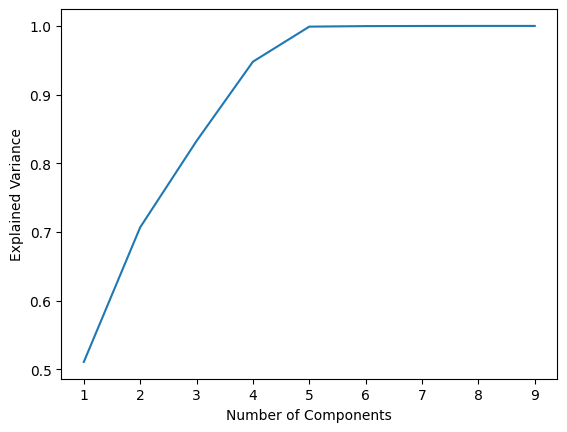

In [29]:
df , number_of_regions= tonic_clonic(clinical_data_df)
def variance_per_component(df):
    # Determine the number of columns in the DataFrame
    num_columns = df.shape[1]
    # Initialize a list to store the explained variance ratios
    explained_variance_ratios = []
    # Loop over the range from 1 to the number of columns
    for i in range(1, num_columns):
        # Perform PCA with n_components set to the current number
        pca = PCA(n_components=i)
        X_pca = pca.fit_transform(df)
        # Print the explained variance ratio
        explained_variance_ratio = sum(pca.explained_variance_ratio_)
        print(f'Explained variance ratio for {i} components: {explained_variance_ratio}')
        # Add the explained variance ratio to the list
        explained_variance_ratios.append(explained_variance_ratio)
    # Plot the explained variance ratios
    plt.plot(range(1, num_columns), explained_variance_ratios)
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance')
    plt.show()
variance_per_component(df)

PCA with 1 components:
Explained variance ratio: [0.51056347]


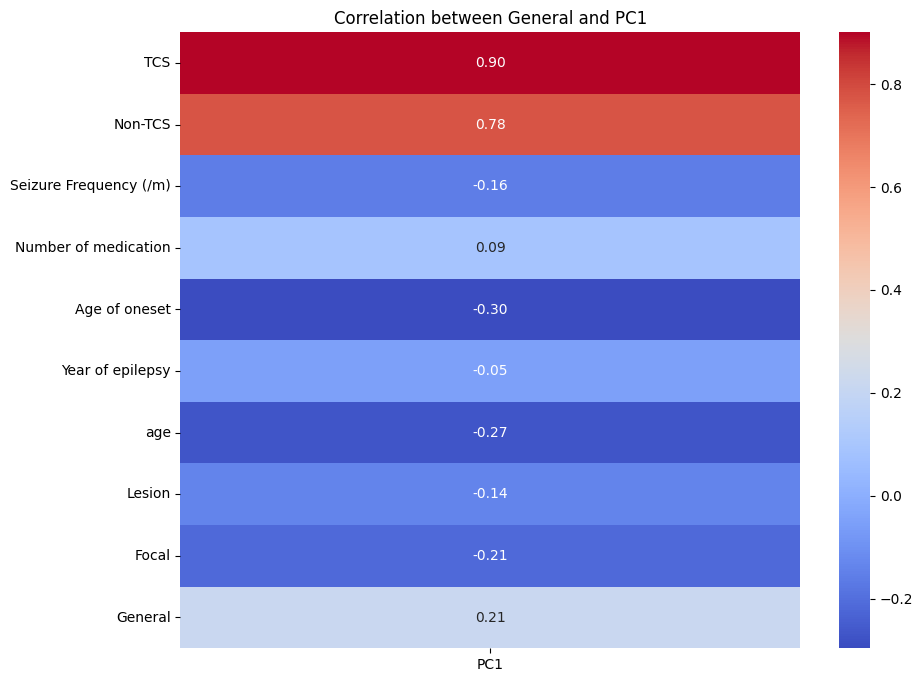

Correlation between PC1 and number of regions: 0.1248018538620388, p-value: 0.38783783318887266
PCA with 2 components:
Explained variance ratio: [0.51056347 0.19605507]


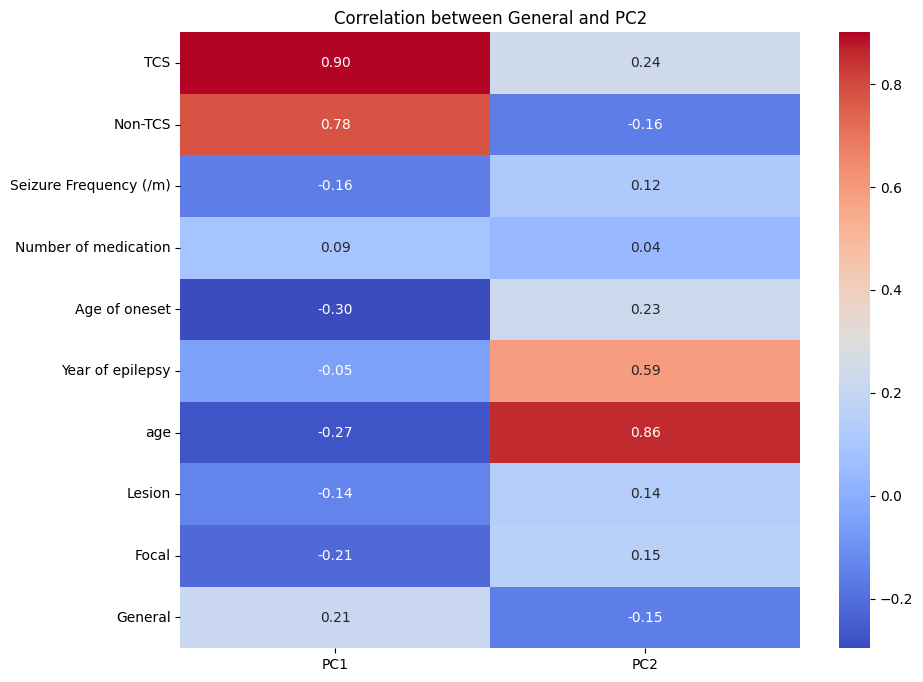

Correlation between PC1 and number of regions: 0.1248018538620388, p-value: 0.38783783318887266
Correlation between PC2 and number of regions: 0.041216316633421596, p-value: 0.7762627149640793
PCA with 3 components:
Explained variance ratio: [0.51056347 0.19605507 0.12578912]


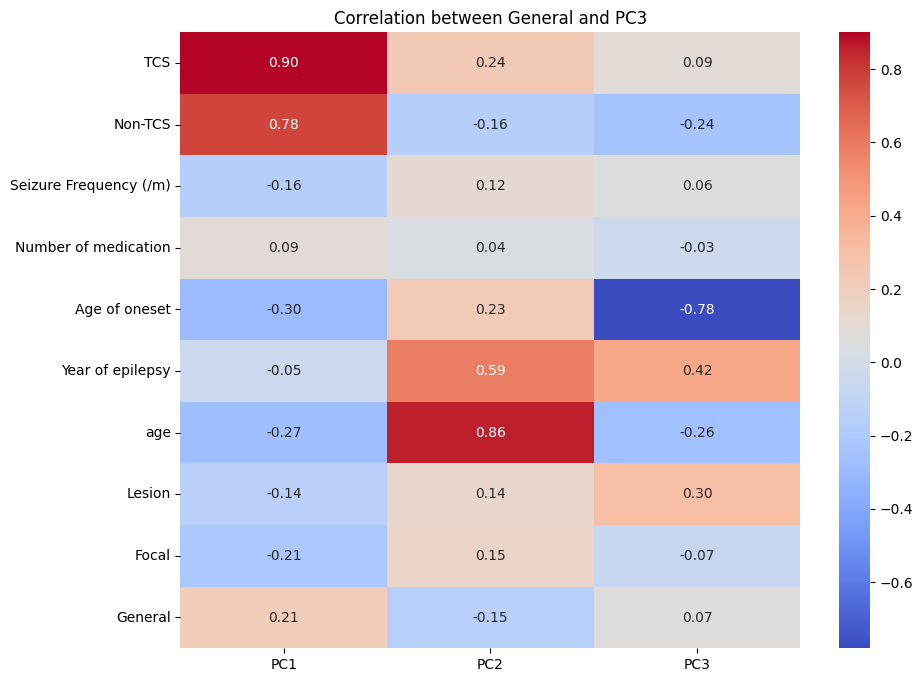

Correlation between PC1 and number of regions: 0.1248018538620388, p-value: 0.38783783318887266
Correlation between PC2 and number of regions: 0.041216316633421596, p-value: 0.7762627149640793
Correlation between PC3 and number of regions: 0.10529856184202813, p-value: 0.4667557403525343


In [30]:
def heatmap_per_component(df,clinical_data_df):
    # Do PCA target column '# regions with BBBD'
    for n in range(1, 4):
        # Perform PCA with n components
        pca = PCA(n_components=n)
        X_pca = pca.fit_transform(df)
        print(f'PCA with {n} components:')
        print('Explained variance ratio:', pca.explained_variance_ratio_)
        # Convert PCA components to DataFrame for easier manipulation
        pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
        # Initialize a DataFrame to store the correlations
        correlation_df = pd.DataFrame(index=df.columns, columns=pca_df.columns)
        
        # Calculate Spearman correlation for each column in df and each column in pca_df
        for column in df.columns:
            for pc in pca_df.columns:
                correlation, _ = spearmanr(df[column], pca_df[pc])
                correlation_df.loc[column, pc] = correlation
        # Convert the correlations to numeric values for plotting
        correlation_df = correlation_df.apply(pd.to_numeric, errors='coerce')
        # sns plot heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_df, cmap='coolwarm', annot=True, fmt='.2f')
        plt.title(f'Correlation between {column} and {pc}')
        plt.show()
        # Correlation between components and number of regions
        for pc in pca_df.columns:
            correlation, p_value = spearmanr(pca_df[pc], number_of_regions)
            print(f'Correlation between {pc} and number of regions: {correlation}, p-value: {p_value}')
heatmap_per_component(df,clinical_data_df)